In [38]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Let's take notes again,

so I should put every process into a process class

but that creates problems! what about parameters?
- i need to create an instance of the process class, within the components, actually... (?) 

also, what about the fluxes?



This is a central question right now, what is the best way to structure the package, based on xsimlab

xsimlab was not written for my kind of applications, it actually is more suitable for agent-based models
i'm doing equation based modeling..

### and at some point in my model I need to define the *_fluxes_*

but where is best? prob in the environment, right? but then what about modification of the ODE?

## what if I put the ODE in a seperate class? would that make any sense?

MODELICA - interesting source on this: https://portal.research.lu.se/ws/files/4779081/8571901.pdf

It defines all components + params + additionally the model equation! (this is missing from xsimlab, somehow--)


In [2]:
IDEa: can keep equation construction separate from model assembly, check all components present before?

Object `before` not found.


In [3]:
could also keep all "MATHS FUNX" outside of xsimlab..

would that increase usability??

I need some way to contruct ODE systems, one component has one flux, right?

so perhaps that is the way, have each component assemble it's flux, and that is passed on to final model

but then how do components interact? components inherits all processes that are part of it's flux, and then later find duplicities automatically?

Nutrient . flux['grazing'] - flux['Z_mortality']

SyntaxError: invalid syntax (<ipython-input-3-7deae310912d>, line 1)

In [ ]:
@xs.process
class Phytoplankton:
    Uptake = xs.foreign(PhytoStdLib,'MichaelisMenten')
    
    

In [ ]:
- write bootstrap model

- then write basic model

and only then adapt all other models

# keep in mind that this is how end user would use models:

In [ ]:
import xsimlab as xs

from ..processes.boundary import BorderBoundary
from ..processes.channel import (StreamPowerChannel,
                                 DifferentialStreamPowerChannelTD)
from ..processes.context import FastscapelibContext
from ..processes.flow import DrainageArea, SingleFlowRouter, MultipleFlowRouter
from ..processes.erosion import TotalErosion
from ..processes.grid import RasterGrid2D
from ..processes.hillslope import LinearDiffusion, DifferentialLinearDiffusion
from ..processes.initial import (BareRockSurface,
                                 Escarpment,
                                 FlatSurface,
                                 NoErosionHistory)
from ..processes.main import (Bedrock,
                              StratigraphicHorizons,
                              SurfaceTopography,
                              SurfaceToErode,
                              TerrainDerivatives,
                              TotalVerticalMotion,
                              UniformSedimentLayer)
from ..processes.marine import MarineSedimentTransport, Sea
from ..processes.tectonics import (BlockUplift,
                                   SurfaceAfterTectonics,
                                   TectonicForcing,
                                   TwoBlocksUplift)


# ``bootstrap_model`` has the minimal set of processes required to
# simulate on a 2D uniform grid the evolution of topographic surface
# under the action of tectonic and erosion processes. None of such
# processes are included. It only provides the "skeleton" of a
# landscape evolution model and might be used as a basis to create
# custom models.

bootstrap_model = xs.Model({
    'grid': RasterGrid2D,
    'fs_context': FastscapelibContext,
    'boundary': BorderBoundary,
    'tectonics': TectonicForcing,
    'surf2erode': SurfaceToErode,
    'erosion': TotalErosion,
    'vmotion': TotalVerticalMotion,
    'topography': SurfaceTopography,
})

# ``basic_model`` is a "standard" landscape evolution model that
# includes block uplift, (bedrock) channel erosion using the stream
# power law and hillslope erosion/deposition using linear
# diffusion. Initial topography is a flat surface with random
# perturbations. Flow is routed on the topographic surface using a D8,
# single flow direction algorithm. All erosion processes are computed
# on a topographic surface that is first updated by tectonic forcing
# processes.

basic_model = bootstrap_model.update_processes({
    'uplift': BlockUplift,
    'surf2erode': SurfaceAfterTectonics,
    'flow': SingleFlowRouter,
    'drainage': DrainageArea,
    'spl': StreamPowerChannel,
    'diffusion': LinearDiffusion,
    'terrain': TerrainDerivatives,
    'init_topography': FlatSurface,
    'init_erosion': NoErosionHistory
})

In [ ]:
# NOTE TO SELF:
Encapsulation as used by xsimlab does not work with equations!

"""Due to the acausal nature of equations it is impossible to enforce encapsulation of
equations in partial components for a library developer who provides partial models. - Modelica Thesis"""

In [ ]:
SO: somehow, equations need to be generated from higher_level_process!
    
    
    hm, instead of having higher level process, how about all components that modify ODE have a mixin class, that keeps track of all the ODE components, and then later calling that
    parent class functionality returns all components fluxes and assembles ODE
    
    how to specify interaction? this needs to be set down in this class, and then specified in each process, like [1,'p',-1,'N']
    to make this extensible there needs to be a conversion step between each process (the possibility should be there)
    
    need to propagate component properties & parameters at Model instance level to all components, similar to how fs_context[''] returns all relevant properties of the fastscape model

In [ ]:
Group variables is the way to go to allow for modularity!!



In [ ]:
import numpy as np
import xsimlab as xs

from .grid import UniformRectilinearGrid2D


@xs.process
class TotalErosion:
    """Sum up all erosion processes."""

    erosion_vars = xs.group('erosion')

    cumulative_height = xs.variable(
        dims=[(), ('y', 'x')],
        intent='inout',
        description='erosion height accumulated over time'
    )

    height = xs.variable(
        dims=[(), ('y', 'x')],
        intent='out',
        description='total erosion height at current step',
        groups='surface_downward'
    )

    rate = xs.on_demand(
        dims=[(), ('y', 'x')],
        description='total erosion rate at current step'
    )

    grid_area = xs.foreign(UniformRectilinearGrid2D, 'area')

    domain_rate = xs.on_demand(
        description='domain-integrated volumetric erosion rate'
    )

    @xs.runtime(args='step_delta')
    def run_step(self, dt):
        self._dt = dt

        self.height = sum(self.erosion_vars)
        self.cumulative_height += self.height

    @rate.compute
    def _rate(self):
        return self.height / self._dt

    @domain_rate.compute
    def _domain_rate(self):
        return np.sum(self.height) * self.grid_area / self._dt

In [6]:
@xs.process
class Testmodel:
    # great thing about on_demand vars is that they are not computed, if they are not called! so computationaly efficient modularity
    test = xs.on_demand() 
    
    groupthing = xs.group('xxxy')
    
    @test.compute
    def _test(self):
        return 1
    
    def initialize(self):
        pass
    
    def run_step(self):

        print(list(self.groupthing))
    
@xs.process
class GroupSupply:
    rallye = xs.variable(default=0.1, groups='xxxy')
    
@xs.process
class GroupSupply2:
    rallye3 = xs.variable(default=0.1, groups='xxxy')
    
tescht = xs.Model({'tm':Testmodel, 'gs':GroupSupply, 'gs2':GroupSupply2})

t_in = xs.create_setup(
        model=tescht,
    clocks={
         'time': [0,1,2,3]  # 10*365,10*365*9)
     },
    input_vars={
    },
    output_vars={
    }
)

t_in.xsimlab.run(model=tescht)

[0.1, 0.1]
[0.1, 0.1]
[0.1, 0.1]


<xarray.Dataset>
Dimensions:       (time: 4)
Coordinates:
  * time          (time) int64 0 1 2 3
Data variables:
    gs2__rallye3  float64 0.1
    gs__rallye    float64 0.1

In [80]:
@xs.process
class Phytoplankton:
    label_prefix = xs.variable(default='P')
    np = xs.variable(description='number of instances')
    
    #np = xs.index(dims='p_number')
    # note `dims` that allows either a unique instance or multiple instances
    label = xs.variable(dims=[(),'p_number'], groups='label', intent='out')
    init = xs.variable(dims=[(), 'p_number'], intent='in', groups='init')
    size = xs.variable(dims=[(), 'p_number'], intent='in', groups='size')

    # this component property is the same for all instances
    param1 = xs.variable()

    # this component property might have different values for instances
    param2 = xs.variable(dims=[(),'p_number'])

    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix
        
    def run_step(self):
        print(self.label)
        print(self.param2)

In [ ]:
@xs.process
class TESTCLASS:
    remineralization = xs.variable(dims=[(),'x'], groups='dNdt', intent=out)
    

In [82]:
phytest = xs.Model({'P':Phytoplankton})

p_in = xs.create_setup(
        model=phytest,
    clocks={
         'time': [0,1,2,3]  # 10*365,10*365*9)
     },
    input_vars={
        'P__np':7,
        'P__init':1,
        'P__param1':1,
        'P__param2':[2,3,4,5,6,7,8],
        'P__size':4,
    },
    output_vars={
        'P__label':'time'
    }
)

p_out = p_in.xsimlab.run(model=phytest)

['P-1' 'P-2' 'P-3' 'P-4' 'P-5' 'P-6' 'P-7']
[2 3 4 5 6 7 8]
['P-1' 'P-2' 'P-3' 'P-4' 'P-5' 'P-6' 'P-7']
[2 3 4 5 6 7 8]
['P-1' 'P-2' 'P-3' 'P-4' 'P-5' 'P-6' 'P-7']
[2 3 4 5 6 7 8]


In [76]:
p_out

<xarray.Dataset>
Dimensions:          (p_number: 7, time: 4)
Coordinates:
  * time             (time) int64 0 1 2 3
Dimensions without coordinates: p_number
Data variables:
    P__init          int64 1
    P__label         (time, p_number) <U3 'P-1' 'P-2' 'P-3' ... 'P-6' 'P-7'
    P__label_prefix  <U1 'P'
    P__np            int64 7
    P__param1        int64 1
    P__param2        (p_number) int64 2 3 4 5 6 7 8
    P__size          int64 4

In [75]:
p_out.sel({'time':1}).sum('p_number')

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       int64 1
Data variables:
    P__init    int64 1
    P__np      int64 7
    P__param1  int64 1
    P__param2  int64 35
    P__size    int64 4

What to keep track of in the most basic build:

ERSEM is my inspiration! JB done did it.. but in Fortran, and it is hella complicated


pelagic_base class
    composition = (either n or s or x...) nitrate, silicate, etc.  
    
but in ERSEM, everything is built up of thousands of if statements, checking this and registering that, in case composition is n,s,x etc. THis is now what I have in mind for my package.. at least for the base it should be much simpler..


but how could I adapt that to my setting?

I'd need to pass a few arguments to a base class, full of optional properties, and create the base class according to the argument recipe.

& also importantly, this is completely step based! no equations
but still have to check how model is actually solved!!


hm.. could I have a function that is like: register()
    and then this is what is passed to higher level process, that creates full model?
    
it REALLY is like that. ERSEM is built up of so many if_statements, don't like.. need to have a simpler organizing principle. xs.group is pretty good for that!

but again, main problem is component interaction, 
but this in the end relies on keeping one 

In [83]:
OKay, so xsimlab actually deals really well with higher complications, such as running models in a grid

through a combination of dimensions and group variables.

Essentially I can assemble all fluxes from xs.groups
I should! that makes it flexible

but how?

SyntaxError: invalid syntax (<ipython-input-83-4a5cf071fa07>, line 1)

In [25]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [26]:
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        #print(list(self.u_vars))
        self._delta_u = sum((v for v in self.u_vars))
        
        #print('hey',list(self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u

In [27]:
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

In [28]:
a = ((i for i in [1,2,3]) for x in [1,2,3])

In [29]:
list(a)

[<generator object <genexpr>.<genexpr> at 0x11dddf970>,
 <generator object <genexpr>.<genexpr> at 0x11dddfba0>,
 <generator object <genexpr>.<genexpr> at 0x11dddf7b0>]

SO:
    this kinda works like layers on a cake, you have one basic structure of model (like an array or matrix)
this means I gotta be smart with dimensions and numpy though!

so Instead of UniformGrid1D, I have NPZD class, that creates array,
then each subclass modifies this array and all fluxes are aggregated  via groups!

isn't this sort of what Benoît built?? let's check
no, it is absolutely convoluted! don't wanna go down that route...

In [30]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [31]:
advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

In [32]:
@xs.process
class SourcePoint:
    """Source point for quantity `u`.

    The location of the source point is adjusted to coincide with
    the nearest node the grid.

    """

    loc = xs.variable(description="source location")
    flux = xs.variable(description="source flux")
    x = xs.foreign(UniformGrid1D, "x")
    u_source = xs.variable(dims="x", intent="out", groups="u_vars")

    @property
    def nearest_node(self):
        idx = np.abs(self.x - self.loc).argmin()
        return idx

    @property
    def source_rate(self):
        src_array = np.zeros_like(self.x)
        src_array[self.nearest_node] = self.flux
        return src_array

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.u_source = self.source_rate * dt

In [33]:
in_ds = xs.create_setup(
     model=advect_model,
     clocks={
         'time': np.linspace(0., 1., 1001),
         'otime': [0, 0.1, 0.5, 1]
     },
     master_clock='time',
     input_vars={
         'grid': {'length': 1.5, 'spacing': 0.01},
         'init': {'loc': 0.3, 'scale': 0.1},
         'advect__v': 1.
     },
     output_vars={
         'profile__u': 'otime'
     }
 )

In [34]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    out_ds = in_ds.xsimlab.run(model=advect_model, parallel=True)

██████████ 100% | Simulation finished in 00:05 


In [35]:
out_ds.to_netcdf('justatest.nc')

In [36]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    out_ds = in_ds.xsimlab.run(model=advect_model, parallel=False)

██████████ 100% | Simulation finished in 00:01 


In [37]:
out_ds.to_netcdf('justatest.nc')

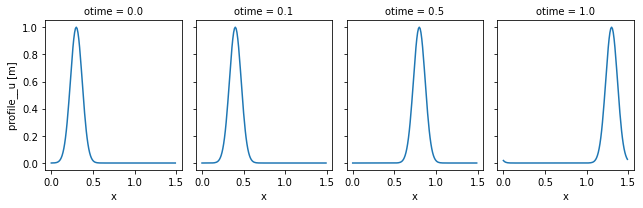

In [190]:
out_ds.profile__u.plot(col='otime', figsize=(9, 3));

In [ ]:
I should use an index for components! initialize in model assembly!



In [179]:
okay,so let's actually start and build a new chemostat prototype

Needs to be able to:
    - flexible addition & interaction of state variables
    - allow for solve via run_step AND odeint or solve_ivp
    

SyntaxError: invalid syntax (<ipython-input-179-845d965c17f0>, line 1)

In [ ]:
@xs.process
class Phytoplankton:
    label_prefix = xs.variable(default='P')
    np = xs.variable(description='number of instances')
    
    #np = xs.index(dims='p_number')
    # note `dims` that allows either a unique instance or multiple instances
    label = xs.variable(dims=[(),'p_number'], groups='label', intent='out')
    init = xs.variable(dims=[(), 'p_number'], intent='in', groups='init')
    size = xs.variable(dims=[(), 'p_number'], intent='in', groups='size')

    # this component property is the same for all instances
    param1 = xs.variable()

    # this component property might have different values for instances
    param2 = xs.variable(dims=[(),'p_number'])

    def initialize(self):
        if self.np:
            self.label = np.array([f"{self.label_prefix}-{i+1}" for i in range(self.np)])
        else:
            self.label = self.label_prefix
        
    def run_step(self):
        print(self.label)
        print(self.param2)

In [ ]:
# this is the base class for a flux (potentially need to add more specificy)
@xs.process
class ChannelErosion:
    """Base class for continental channel erosion and/or deposition.
    Do not use this base class directly in a model! Use one of its
    subclasses instead.
    However, if you need one or several of the variables declared here
    in another process, it is preferable to pass this base class in
    :func:`xsimlab.foreign`.
    """
    erosion = xs.variable(
        dims=('y', 'x'),
        intent='out',
        groups='erosion',
        description='channel erosion and/or deposition'
    )

In [ ]:
@xs.process
class StreamPowerChannel(ChannelErosion):
    """Stream-Power channel erosion."""

    k_coef = xs.variable(
        dims=[(), ('y', 'x')],
        description='bedrock channel incision coefficient'
    )
    area_exp = xs.variable(
        default=0.4,
        description='drainage area exponent'
    )
    slope_exp = xs.variable(
        default=1,
        description='slope exponent'
    )

    shape = xs.foreign(UniformRectilinearGrid2D, 'shape')
    elevation = xs.foreign(FlowRouter, 'elevation')
    receivers = xs.foreign(FlowRouter, 'receivers')
    flowacc = xs.foreign(FlowAccumulator, 'flowacc')
    fs_context = xs.foreign(FastscapelibContext, 'context')

    chi = xs.on_demand(
        dims=('y', 'x'),
        description='integrated drainage area (chi)'
    )

    def _set_g_in_context(self):
        # transport/deposition feature is exposed in subclasses
        self.fs_context["g1"] = 0.
        self.fs_context["g2"] = 0.

    def run_step(self):
        kf = np.broadcast_to(self.k_coef, self.shape).flatten()
        self.fs_context["kf"] = kf

        # we don't use kfsed fastscapelib-fortran feature directly
        self.fs_context["kfsed"] = -1.

        self._set_g_in_context()

        self.fs_context["m"] = self.area_exp
        self.fs_context["n"] = self.slope_exp

        # bypass fastscapelib_fortran global state
        self.fs_context["h"] = self.elevation.flatten()

        # TODO: https://github.com/fastscape-lem/fastscapelib-fortran/pull/25
        # this has no effect yet.
        self.fs_context["a"] = self.flowacc.flatten()

        if self.receivers.ndim == 1:
            fs.streampowerlawsingleflowdirection()
        else:
            fs.streampowerlaw()

        erosion_flat = self.elevation.ravel() - self.fs_context["h"]
        self.erosion = erosion_flat.reshape(self.shape)

    @chi.compute
    def _chi(self):
        chi_arr = np.empty_like(self.elevation, dtype='d')
        self.fs_context["copychi"](chi_arr.ravel())

        return chi_arr

In [ ]:
@xs.process
class TotalErosion:
    """Sum up all erosion processes."""

    erosion_vars = xs.group('erosion')

    cumulative_height = xs.variable(
        dims=[(), ('y', 'x')],
        intent='inout',
        description='erosion height accumulated over time'
    )

    height = xs.variable(
        dims=[(), ('y', 'x')],
        intent='out',
        description='total erosion height at current step',
        groups='surface_downward'
    )

    rate = xs.on_demand(
        dims=[(), ('y', 'x')],
        description='total erosion rate at current step'
    )

    grid_area = xs.foreign(UniformRectilinearGrid2D, 'area')

    domain_rate = xs.on_demand(
        description='domain-integrated volumetric erosion rate'
    )

    @xs.runtime(args='step_delta')
    def run_step(self, dt):
        self._dt = dt

        self.height = sum(self.erosion_vars)
        self.cumulative_height += self.height

    @rate.compute
    def _rate(self):
        return self.height / self._dt

    @domain_rate.compute
    def _domain_rate(self):
        return np.sum(self.height) * self.grid_area / self._dt

In [ ]:
# this will be the very core of the model, where i keep track of all shared properties in a context xs.any_object()
# can drastically simplify this, but need to replace fastscapelib_fortran with my own "core" (or keep it here!)

from .grid import UniformRectilinearGrid2D


class SerializableFastscapeContext:
    """Fastscapelib-fortran context getter/setter that is serializable.
    (Fortran objects can't be pickled).
    """

    def __getitem__(self, key):
        return getattr(fs.fastscapecontext, key)

    def __setitem__(self, key, value):
        setattr(fs.fastscapecontext, key, value)


@xs.process
class FastscapelibContext:
    """This process takes care of proper initialization,
    update and clean-up of fastscapelib-fortran internal
    state.
    """
    shape = xs.foreign(UniformRectilinearGrid2D, 'shape')
    length = xs.foreign(UniformRectilinearGrid2D, 'length')

    context = xs.any_object(
        description='accessor to fastscapelib-fortran internal variables'
    )

    def initialize(self):
        fs.fastscape_init()
        fs.fastscape_set_nx_ny(*np.flip(self.shape))
        fs.fastscape_setup()
        fs.fastscape_set_xl_yl(*np.flip(self.length))

        self.context = SerializableFastscapeContext()

    @xs.runtime(args='step_delta')
    def run_step(self, dt):
        # fastscapelib-fortran runtime routines use dt from context
        self.context["dt"] = dt

    def finalize(self):
        fs.fastscape_destroy()

In [ ]:
# this needs to be the base grid, kinda.. if I want to add dimensionality.
# but the equations/ODE should be like this but 1D

@xs.process
class UniformRectilinearGrid2D:
    """Create a uniform rectilinear (static) 2-dimensional grid."""

    shape = xs.variable(
        dims='shape_yx',
        description='nb. of grid nodes in (y, x)',
        static=True
    )
    spacing = xs.variable(
        dims='shape_yx',
        description='grid node spacing in (y, x)',
        static=True
    )
    origin = xs.variable(
        dims='shape_yx',
        description='(y, x) coordinates of grid origin',
        static=True
    )

    length = xs.variable(
        dims='shape_yx',
        intent='out',
        description='total grid length in (y, x)'
    )
    size = xs.variable(
        intent='out',
        description='total nb. of nodes'
    )
    area = xs.variable(
        intent='out',
        description='total grid area'
    )
    cell_area = xs.variable(
        intent='out',
        description='fixed grid cell area'
    )

    dx = xs.variable(
        intent='out',
        description="grid spacing in x (cols)"
    )
    dy = xs.variable(
        intent='out',
        description="grid spacing in y (rows)"
    )

    nx = xs.variable(
        intent='out',
        description="nb. of nodes in x (cols)"
    )
    ny = xs.variable(
        intent='out',
        description="nb. of nodes in y (rows)"
    )

    x = xs.index(dims='x', description='grid x coordinate')
    y = xs.index(dims='y', description='grid y coordinate')

    def _set_length_or_spacing(self):
        self.length = (self.shape - 1) * self.spacing

    def initialize(self):
        self._set_length_or_spacing()
        self.size = np.prod(self.shape)
        self.area = np.prod(self.length)
        self.cell_area = np.prod(self.spacing)

        self.dx = self.spacing[1]
        self.dy = self.spacing[0]
        self.nx = self.shape[1]
        self.ny = self.shape[0]

        self.x = np.linspace(self.origin[1],
                             self.origin[1] + self.length[1],
                             self.shape[1])
        self.y = np.linspace(self.origin[0],
                             self.origin[0] + self.length[0],
                             self.shape[0])


@xs.process
class RasterGrid2D(UniformRectilinearGrid2D):
    """Create a raster 2-dimensional grid."""

    length = xs.variable(
        dims='shape_yx',
        intent='in',
        description='total grid length in (y, x)',
        static=True
    )
    origin = xs.variable(
        dims='shape_yx',
        intent='out',
        description='(y, x) coordinates of grid origin'
    )
    spacing = xs.variable(
        dims='shape_yx',
        intent='out',
        description='grid node spacing in (y, x)'
    )

    def _set_length_or_spacing(self):
        self.spacing = self.length / (self.shape - 1)

    def initialize(self):
        self.origin = np.array([0., 0.])
        super(RasterGrid2D, self).initialize()

In [ ]:
# and the actual functions need to be applicable to the arrays via numpy functions, not 

In [ ]:
# def need this in the beginning
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    
    # for indexing xarray IO objects
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days

In [ ]:
# This definitely also makes sense, but just as construction help for future components (and building block of the current ones)
@xs.process
class Component:
    """Base class for a component of a ecosystem."""

    label = xs.variable(groups='c_labels', description='component label')
    
    c0 = xs.variable(
        # only slab model (scalar)
        dims=(), 
        # support slab + 2D models ?
        #dims=[(), ('lat', 'lon')],
        groups='c_c0',
        description='inital concentration'
    )

In [ ]:
# this is where the index for all components get's created, to store output nicely in xarray base
@xs.process
class AllComponents:
    """Group some component propreties as 1-d arrays."""
    
    c_labels = xs.group('c_labels')
    c_c0 = xs.group('c_c0')
    
    labels = xs.variable(
        dims='component',
        intent='out',
        description='component labels'
    )
    c0 = xs.variable(
        dims='component',
        intent='out',
        description='initial concentration'
    )
    
    # use component labels as xarray coordinate/index
    component = xs.index(
        dims='component',
        description='component label'
    )
    
    def initialize(self):
        self.labels = np.array(list(self.c_labels))
        self.component = self.labels
        self.c0 = np.array(list(self.c_c0), dtype=np.double)

In [ ]:
# like this, but mainly needs to collect all processes acting at the 0D model level
# and add them all up, and store them in the "c" variable, which I might rename "state"
# This way all fluxes could possibly be stored with model output!(i.e. in other subprocesses or here)

@xs.process
class Slab:
    time = xs.foreign(Time, 'time')
    
    c = xs.variable(
        dims=('time', 'component'),
        intent='out',
        description='component concentrations',
        attrs={'units': 'micromol N L^-1'}
    )

In [ ]:
# add forcing like this:
@xs.process
class TectonicForcing:
    """Sum up all tectonic forcing processes and their effect on the
    vertical motion of the bedrock surface and the topographic
    surface, respectively.
    """
    bedrock_forcing_vars = xs.group('bedrock_forcing_upward')
    surface_forcing_vars = xs.group('surface_forcing_upward')

    bedrock_upward = xs.variable(
        dims=[(), ('y', 'x')],
        intent='out',
        groups='bedrock_upward',
        description='imposed vertical motion of bedrock surface'
    )

    surface_upward = xs.variable(
        dims=[(), ('y', 'x')],
        intent='out',
        groups='surface_upward',
        description='imposed vertical motion of topographic surface'
    )

    grid_area = xs.foreign(UniformRectilinearGrid2D, 'area')

    domain_rate = xs.on_demand(
        description='domain-integrated volumetric tectonic rate'
    )

    @xs.runtime(args='step_delta')
    def run_step(self, dt):
        self._dt = dt

        self.bedrock_upward = sum(self.bedrock_forcing_vars)
        self.surface_upward = sum(self.surface_forcing_vars)

    @domain_rate.compute
    def _domain_rate(self):
        return np.sum(self.surface_upward) * self.grid_area / self._dt

@xs.process
class SurfaceAfterTectonics(SurfaceToErode):
    """Used for the computation erosion processes after
    applying tectonic forcing.
    """
    topo_elevation = xs.foreign(SurfaceTopography, 'elevation')

    forced_motion = xs.foreign(TectonicForcing, 'surface_upward')

    elevation = xs.variable(
        dims=('y', 'x'),
        intent='out',
        description='surface elevation before erosion'
    )

    def run_step(self):
        self.elevation = self.topo_elevation + self.forced_motion

In [ ]:
# and this is the actual, place where the math happens, fluxes are summed up and calculated in the array
@xs.process
class TotalVerticalMotion:
    """Sum up all vertical motions of bedrock and topographic surface,
    respectively.
    Vertical motions may result from external forcing, erosion and/or
    feedback of erosion on tectonics (isostasy).
    """
    bedrock_upward_vars = xs.group('bedrock_upward')
    surface_upward_vars = xs.group('surface_upward')
    surface_downward_vars = xs.group('surface_downward')

    bedrock_upward = xs.variable(
        dims=('y', 'x'),
        intent='out',
        description='bedrock motion in upward direction'
    )
    surface_upward = xs.variable(
        dims=('y', 'x'),
        intent='out',
        description='topographic surface motion in upward direction'
    )

    def run_step(self):
        self.bedrock_upward = sum(self.bedrock_upward_vars)

        self.surface_upward = (sum(self.surface_upward_vars) -
                               sum(self.surface_downward_vars))
     
    
# the above collects it, the below calculates it (or "updates" it)
@xs.process
class SurfaceTopography:
    """Update the elevation of the (land and/or submarine) surface
    topography.
    """
    elevation = xs.variable(
        dims=('y', 'x'),
        intent='inout',
        description='surface topography elevation'
    )

    motion_upward = xs.foreign(TotalVerticalMotion, 'surface_upward')

    def finalize_step(self):
        self.elevation += self.motion_upward

In [ ]:
# these are specific other calculations.. like forcing? not sure
@xs.process
class SurfaceToErode:
    """Defines the topographic surface used for the computation of erosion
    processes.
    In this process class, it simply corresponds to the topographic
    surface, unchanged, at the current time step.
    Sometimes it would make sense to compute erosion processes after
    having applied other processes such as tectonic forcing. This
    could be achieved by subclassing.
    """
    topo_elevation = xs.foreign(SurfaceTopography, 'elevation')

    elevation = xs.variable(
        dims=('y', 'x'),
        intent='out',
        description='surface elevation before erosion'
    )

    def run_step(self):
        self.elevation = self.topo_elevation

In [ ]:
# These are all "sub"-processes that call TotalVerticalMotion and modify it somehow

@xs.process
class Bedrock:
    """Update the elevation of bedrock (i.e., land and/or submarine
    basement).
    """
    elevation = xs.variable(
        dims=('y', 'x'),
        intent='inout',
        description='bedrock elevation'
    )

    depth = xs.on_demand(
        dims=('y', 'x'),
        description='bedrock depth below topographic surface'
    )

    bedrock_motion_up = xs.foreign(TotalVerticalMotion, 'bedrock_upward')
    surface_motion_up = xs.foreign(TotalVerticalMotion, 'surface_upward')

    surface_elevation = xs.foreign(SurfaceTopography, 'elevation')

    @depth.compute
    def _depth(self):
        return self.surface_elevation - self.elevation

    def initialize(self):
        if np.any(self.elevation > self.surface_elevation):
            raise ValueError("Encountered bedrock elevation higher than "
                             "topographic surface elevation.")

    def run_step(self):
        self._elevation_next = np.minimum(
            self.elevation + self.bedrock_motion_up,
            self.surface_elevation + self.surface_motion_up
        )

    def finalize_step(self):
        self.elevation = self._elevation_next


@xs.process
class UniformSedimentLayer:
    """Uniform sediment (or regolith, or soil) layer.
    This layer has uniform properties (undefined in this class) and
    generally undergo under active erosion, transport and deposition
    processes.
    """

    surf_elevation = xs.foreign(SurfaceTopography, 'elevation')
    bedrock_elevation = xs.foreign(Bedrock, 'elevation')

    thickness = xs.variable(
        dims=('y', 'x'),
        intent='out',
        description='sediment layer thickness'
    )

    @thickness.compute
    def _get_thickness(self):
        return self.surf_elevation - self.bedrock_elevation

    def initialize(self):
        self.thickness = self._get_thickness()

    def run_step(self):
        self.thickness = self._get_thickness()


@xs.process
class TerrainDerivatives:
    """Compute, on demand, terrain derivatives such as slope or
    curvature.
    """
    shape = xs.foreign(UniformRectilinearGrid2D, 'shape')
    spacing = xs.foreign(UniformRectilinearGrid2D, 'spacing')
    elevation = xs.foreign(SurfaceTopography, 'elevation')

    slope = xs.on_demand(
        dims=('y', 'x'),
        description='terrain local slope'
    )
    curvature = xs.on_demand(
        dims=('y', 'x'),
        description='terrain local curvature'
    )

    @slope.compute
    def _slope(self):
        slope = np.empty_like(self.elevation)
        ny, nx = self.shape
        dy, dx = self.spacing

        fs.slope(self.elevation.ravel(), slope.ravel(), nx, ny, dx, dy)

        return slope

    @curvature.compute
    def _curvature(self):
        curv = np.empty_like(self.elevation)
        ny, nx = self.shape
        dy, dx = self.spacing

        fs.curvature(self.elevation.ravel(), curv.ravel(), nx, ny, dx, dy)

        return curv


@xs.process
class StratigraphicHorizons:
    """Generate a fixed number of stratigraphic horizons.
    A horizon is active, i.e., it tracks the evolution of the
    land/submarine topographic surface until it is "frozen" at a given
    time. Beyond this freezing (or deactivation) time, the horizon
    will only be affected by tectonic deformation and/or erosion.
    To compute diagnostics on those horizons, you can create a
    subclass where you can add "on_demand" variables.
    """
    freeze_time = xs.variable(
        dims='horizon',
        description='horizon freezing (deactivation) time',
        static=True
    )

    horizon = xs.index(dims='horizon', description='horizon number')

    active = xs.variable(
        dims='horizon',
        intent='out',
        description='whether the horizon is active or not'
    )

    surf_elevation = xs.foreign(SurfaceTopography, 'elevation')
    elevation_motion = xs.foreign(TotalVerticalMotion, 'surface_upward')
    bedrock_motion = xs.foreign(TotalVerticalMotion, 'bedrock_upward')

    elevation = xs.variable(
        dims=('horizon', 'y', 'x'),
        intent='out',
        description='elevation of horizon surfaces'
    )

    @xs.runtime(args='sim_start')
    def initialize(self, start_time):
        if np.any(self.freeze_time < start_time):
            raise ValueError("'freeze_time' value must be greater than the "
                             "time of the beginning of the simulation")

        self.elevation = np.repeat(self.surf_elevation[None, :, :],
                                   self.freeze_time.size,
                                   axis=0)

        self.horizon = np.arange(0, len(self.freeze_time))

        self.active = np.full_like(self.freeze_time, True, dtype=bool)

    @xs.runtime(args='step_start')
    def run_step(self, current_time):
        self.active = current_time < self.freeze_time

    def finalize_step(self):
        elevation_next = self.surf_elevation + self.elevation_motion

        self.elevation[self.active] = elevation_next

        self.elevation[~self.active] = np.minimum(
            self.elevation[~self.active] + self.bedrock_motion,
            elevation_next
        )

In [ ]:
# another instance of how to create kinds of processes that can interact with other processes
# like the process takes the whole array 1D of state variables, but only modifies the ones it should [like all 'P's etc.]
@xs.process
class BaseIsostasy:
    """Base class for isostasy.
    Do not use this base class directly in a model! Use one of its
    subclasses instead.
    However, if you need one or several of the variables declared here
    in another process, it is preferable to pass this base class in
    :func:`xsimlab.foreign`.
    """
    rebound = xs.variable(
        dims=('y', 'x'),
        intent='out',
        groups=['bedrock_upward', 'surface_upward'],
        description='isostasic rebound due to material loading/unloading'
    )

In [39]:
# okay, and this is how to build the chemostat, so that it is flexibly constructed
# it defines the physical environment and collects all necessary variables

# yea, this is where it gets calculated, adds fluxes
@xs.process
class Sea:
    """Sea level."""

    # TODO: add diagnostics like shoreline extraction or
    # continental area vs. marine masks.

    level = xs.variable(
        default=0.,
        description='sea level (elevation)'
    )


@xs.process
class MarineSedimentTransport:
    """Marine sediment transport, deposition and compaction.
    The source of sediment used for marine transport originates from
    channel erosion and/or transport, which, integrated over the whole
    continental area, provides a volume of sediment yielded through
    the shoreline.
    A uniform, user-defined ratio of sand/silt is considered for this
    sediment yield. Each of these grain size category has its own
    properties like porosity, the exponential decreasing of porosity
    with depth and the transport coefficient (diffusivity).
    """
    ss_ratio_land = xs.variable(
        description='sand/silt ratio of continental sediment source'
    )
    ss_ratio_sea = xs.variable(
        dims=('y', 'x'),
        intent='out',
        description='sand/silt ratio of marine sediment layer'
    )

    porosity_sand = xs.variable(
        description='surface (reference) porosity of sand'
    )
    porosity_silt = xs.variable(
        description='surface (reference) porosity of silt'
    )

    e_depth_sand = xs.variable(
        description='e-folding depth of exp. porosity curve for sand'
    )
    e_depth_silt = xs.variable(
        description='e-folding depth of exp. porosity curve for silt'
    )

    diffusivity_sand = xs.variable(
        description='diffusivity (transport coefficient) for sand'
    )

    diffusivity_silt = xs.variable(
        description='diffusivity (transport coefficient) for silt'
    )

    layer_depth = xs.variable(
        description='mean depth (thickness) of marine active layer'
    )

    shape = xs.foreign(UniformRectilinearGrid2D, 'shape')
    fs_context = xs.foreign(FastscapelibContext, 'context')
    elevation = xs.foreign(SurfaceToErode, 'elevation')
    sediment_source = xs.foreign(ChannelErosion, 'erosion')
    sea_level = xs.foreign(Sea, 'level')

    erosion = xs.variable(
        dims=('y', 'x'),
        intent='out',
        groups='erosion',
        description='marine erosion or deposition of sand/silt'
    )

    def initialize(self):
        # needed so that channel erosion/transport is disabled below sealevel
        self.fs_context["runmarine"] = True

    def run_step(self):
        self.fs_context["ratio"] = self.ss_ratio_land

        self.fs_context["poro1"] = self.porosity_sand
        self.fs_context["poro2"] = self.porosity_silt

        self.fs_context["zporo1"] = self.e_depth_sand
        self.fs_context["zporo2"] = self.e_depth_silt

        self.fs_context["kdsea1"] = self.diffusivity_sand
        self.fs_context["kdsea2"] = self.diffusivity_silt

        self.fs_context["layer"] = self.layer_depth

        self.fs_context["sealevel"] = self.sea_level
        self.fs_context["Sedflux"] = self.sediment_source.ravel()

        # bypass fastscapelib-fortran global state
        self.fs_context["h"] = self.elevation.flatten()

        fs.marine()

        erosion_flat = self.elevation.ravel() - self.fs_context["h"]
        self.erosion = erosion_flat.reshape(self.shape)

        self.ss_ratio_sea = self.fs_context["fmix"].copy().reshape(self.shape)

In [ ]:

@xs.process
class Chemostat:
    
    inputs = xs.group('input')
    outputs = xs.group('output')
    
    components = xs.group('component')
    init_values = xs.group('init')
    
    
    

In [ ]:
# A question that is still open, is whether I should call these subproccesses like:
# Flux vs negative Flux, postitive FLux vs. Grazing, LightHarvesting, etc. and then they just act on the subgroups..
# would be more economical with the arrays for sure, but might make it much trickier to combine in total 
state

the question here, what is the state, structurally
is it a dict, keeping all labels
or is it actually a flattened array, and I can draw the relevant components from the labels
so that each process get's what it needs, but as an array (multidimensional component)

the way to get further dimensions is via higher dimension processes

